In [9]:
import os
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import clear_output

## MNIST dataset + dataloader

In [42]:
root = './data'

trans = transforms.Compose([transforms.ToTensor()])

train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

train_loader = torch.utils.data.DataLoader(train_set,batch_size=32,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=32,shuffle=False)

## plot some random examples:

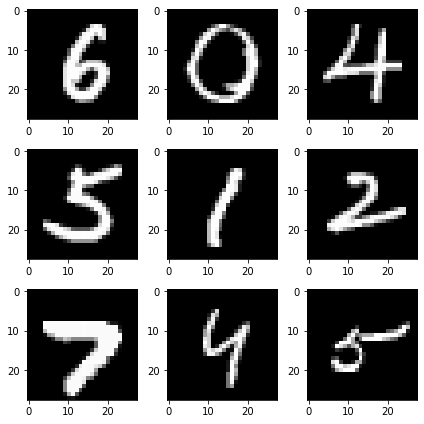

In [3]:
fig,ax = plt.subplots(3,3,figsize=(6,6))

for axlist in ax:
    for ax_i in axlist:
        idx = np.random.randint(len(train_set))
        img = train_set[idx][0]

        ax_i.imshow( img.data.numpy().reshape(28,28) ,cmap='gray')

plt.tight_layout()
plt.show()

## first lets create a regular autoencoder (not variational)

In [11]:
latent_dim = 2

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 400)
        self.fc3 = nn.Linear(400, latent_dim)
       
        self.relu = nn.ReLU()
        
    def forward(self,x):
        
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        
        return self.fc3(out)
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.fc1 = nn.Linear(latent_dim, 400)
        self.fc2 = nn.Linear(400, 400)
        self.fc3 = nn.Linear(400, 784)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        
        return out
    
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.enc = Encoder()
        self.dec = Decoder()

    def forward(self, x):
        
        z = self.enc(x.view(-1, 784))
        
        out = self.dec(z)
        
        return out



In [12]:
net = AutoEncoder()
loss_func = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4) 

if torch.cuda.is_available():
    net.cuda()

net.train()

for epoch in range(10) :
    print(epoch)
    for x,_ in tqdm( train_loader):
        optimizer.zero_grad()
        
        
        if torch.cuda.is_available():
            x = x.cuda()
        prediction = net(x)
        
        
        mse_loss = loss_func(prediction, x.view(-1,784)) # <-- note that i'm using the input as the target
         
        
        mse_loss.backward()
        optimizer.step()
        
    clear_output(wait=True)

    

9


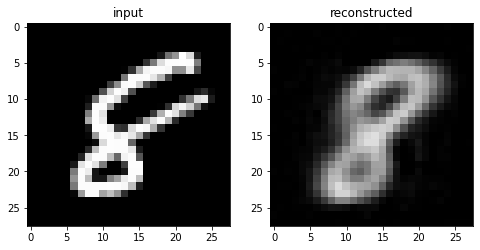

In [44]:
fig,ax = plt.subplots(1,2,figsize=(8,4))

net.cpu()
net.eval()

img = train_set[485][0]

decoded = net(img).data.numpy().reshape(28,28)

ax[0].imshow( img.data.numpy().reshape(28,28) ,cmap='gray',vmin=0,vmax=1)
ax[1].imshow( decoded ,cmap='gray',vmin=0,vmax=1)

ax[0].set_title('input')
ax[1].set_title('reconstructed')

plt.show()

## the image is kind of blurry, which is a common feature of autoencoders
## so lets introduce something call perceptual loss

the basic idea - use another neural network as a loss function

given network that is trained on the data to do some task (like classification)
the first layers are "feature extractors"
pass both the original image, and the reconstructed image, through the same layers, and ask that the autoencoder minize the distance between the activations

https://arxiv.org/pdf/1610.00291.pdf
https://arxiv.org/abs/1603.08155

## step 1, train a classifier (if you don't have one ready)

In [14]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier,self).__init__()
        self.conv1 = nn.Conv2d(1,64,3)
        self.conv2 = nn.Conv2d(64, 30,3)
        self.conv3 = nn.Conv2d(30, 20,3)
        
        self.conv4 = nn.Conv2d(20, 10,3)
        
        self.maxpool = nn.MaxPool2d(2)
        
        self.fc1 = nn.Linear(10*4*4,50)
        self.fc2 = nn.Linear(50,10)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        
        
        out = self.relu( self.conv1(x) )
        
        out = self.relu( self.conv2(out) )
        out = self.relu( self.conv3(out) )
        
        out = self.maxpool(out)
        out = self.relu( self.conv4(out) )
        out = self.maxpool(out)
        
        out = self.relu(self.fc1(out.view(-1,10*4*4)))
        out = self.fc2(out)
        
        return out

In [16]:
classifier = Classifier()

In [ ]:
#use the training loop below, or load the model weights
#classifier.load_state_dict(torch.load('classifier.pt',map_location=torch.device('cpu')))

In [8]:


if torch.cuda.is_available():
    classifier.cuda()

loss_func = nn.CrossEntropyLoss()

optimizer = optim.Adam(classifier.parameters(), lr=1e-3) 

for epoch in range(5) :
    for x,y in tqdm( train_loader):
        optimizer.zero_grad()
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()
            
        prediction = classifier(x)
        loss = loss_func(prediction, y) # <-- now we are training against our digit label as usual
        
        loss.backward()
        optimizer.step()
    clear_output(wait=True)


In [18]:
def compute_accuracy(data_loader,net):
    
    net.eval()
    net.cpu()
    
    total_number = 0
    total_correct = 0
    
    for x,y in data_loader:
        
        prediction = net(x).data.numpy()
        
        prediction = np.argmax(prediction,axis=1)
        
        correct = len( np.where(prediction==y.data.numpy())[0] )
        
        total_correct+=correct
        total_number+=x.shape[0]
        
    return total_correct/float(total_number)

compute_accuracy(test_loader,classifier)

0.9901

## step 2, build a nn.Module that extracts the activations from our original image and reconstructed image, and compares them with L1 loss

In [64]:
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        
        self.activ1 = classifier.conv1

        self.activ2 = classifier.conv2
        
        self.activ3 = classifier.conv3
    
        
        self.activ4 = classifier.conv4
        
        self.maxpool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()

    def get_activ(self,x):
        
        activ1 = self.activ1(x)
        out = self.relu( activ1 )
        activ2 = self.activ2(out)
        out = self.relu( activ2 )
        activ3 = self.activ3(out)
        out = self.relu( activ3 )
        out = self.maxpool(out)
        activ4 = self.activ4(out)
        
        
        return activ1,activ2,activ3,activ4
        
    def forward(self, y, yhat):
        
        a1, a2, a3,a4= self.get_activ(y)
        ap1, ap2,ap3,ap4 = self.get_activ(yhat)

        return torch.nn.functional.l1_loss(a1, ap1)+torch.nn.functional.l1_loss(a2, ap2)+\
                        torch.nn.functional.l1_loss(a3, ap3)+torch.nn.functional.l1_loss(a4, ap4)

In [19]:
net2 = AutoEncoder()

In [ ]:
#net2.load_state_dict(torch.load('AE_with_perceptual_loss.pt',map_location=torch.device('cpu')))

In [15]:
net2 = AutoEncoder()
loss_func = nn.MSELoss()
perp_loss = PerceptualLoss()

optimizer = optim.Adam(net2.parameters(), lr=1e-4) 

if torch.cuda.is_available():
    net2.cuda()
    perp_loss.cuda()

net2.train()

for epoch in range(10) :
    print(epoch)
    for x,_ in tqdm( train_loader):
        optimizer.zero_grad()
        
        
        if torch.cuda.is_available():
            x = x.cuda()
        prediction = net2(x)
        
        
        mse_loss = loss_func(prediction, x.view(-1,784)) # <-- note that i'm using the input as the target
        p_loss = perp_loss(prediction.view(-1,1,28,28), x)
        
        loss = mse_loss+p_loss
        
        loss.backward()
        optimizer.step()

    clear_output(wait=True)

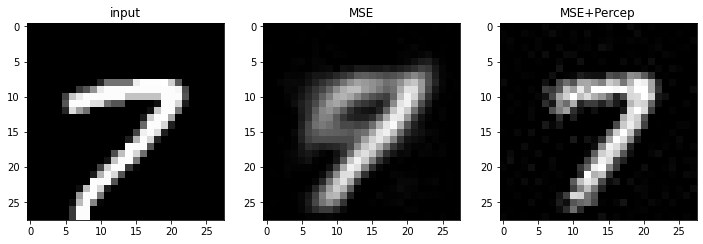

In [51]:
fig,ax = plt.subplots(1,3,figsize=(12,4))

net.cpu()
net.eval()

net2.cpu()
net2.eval()

img = train_set[123][0]


decoded = net(img).data.numpy().reshape(28,28)
decoded2 = net2(img).data.numpy().reshape(28,28)


ax[0].imshow( img.data.numpy().reshape(28,28) ,cmap='gray',vmin=0,vmax=1)
ax[1].imshow( decoded ,cmap='gray',vmin=0,vmax=1)
ax[2].imshow( decoded2 ,cmap='gray',vmin=0,vmax=1)
ax[0].set_title('input')
ax[1].set_title('MSE')
ax[2].set_title('MSE+Percep')
plt.show()

## Now we will add randomness to the AutoEncoder - making it "variational"


## how do we create "randomness" that we can take the derivative of?

have the model predict the mean and std of a normal distribution - then sample from it 
by generating random numbers from 

eps ~ N(0,1),

and using

z = $\mu$ + $\sigma$ * eps

more info here:
https://pytorch.org/docs/stable/distributions.html

In [19]:
## this is the function that generates random numbers from N(0,1)
## it matches the size of the input you give it

torch.randn_like(torch.rand(5,3))

tensor([[ 0.9665,  0.5350,  0.7864],
        [-0.2485, -0.1115,  1.6570],
        [-0.1494,  0.8794,  0.0476],
        [-1.9114, -1.5043,  1.1786],
        [-0.7296, -0.2586, -1.7310]])

In [54]:
latent_dim = 2

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 400)
        self.fc21 = nn.Linear(400, latent_dim)
        self.fc22 = nn.Linear(400, latent_dim)
        self.relu = nn.ReLU()
    def forward(self,x):
        
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        
        return self.fc21(out), self.fc22(out)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.fc1 = nn.Linear(latent_dim, 400)
        self.fc2 = nn.Linear(400, 400)
        
        self.fc3 = nn.Linear(400, 784)
        self.fc4 = nn.Linear(400, 784)
        
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        
        return self.fc3(out),self.fc4(out)


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.enc = Encoder()
        self.dec = Decoder()

    def pick_random(self, mu, logvar):
        
        std = torch.exp(0.5*logvar)
        
        eps = torch.randn_like(std)
        
        return mu + eps*std

    def forward(self, x):
        
        
        mu, logvar = self.enc(x.view(-1, 784))
        
        z = self.pick_random(mu, logvar)
        
        mu_x, logvar_x = self.dec(z)
        
        x_reco = self.pick_random(mu_x, logvar_x)
        
        return x_reco, mu, logvar

In [55]:
vae = VAE()

## let's look at the distribution of encoding values for the untrained model on the test dataset

In [56]:
encoding = {}
encoding_std = {}

n_test = len(test_set)

for test_i in tqdm( range(n_test) ):
    x,y = test_set[test_i]
    
    if y not in encoding:
        encoding[y] = []
        encoding_std[y] = []
        
    enc_mean, enc_std = vae.enc(x.view(-1, 784))
    
    encoding[y].append( enc_mean.data.numpy()[0] )
    encoding_std[y].append( np.exp(0.5*enc_std.data.numpy()[0]) )
    
for key in encoding:
    encoding[key] = np.array(encoding[key])
    encoding_std[key] = np.array(encoding_std[key])
    

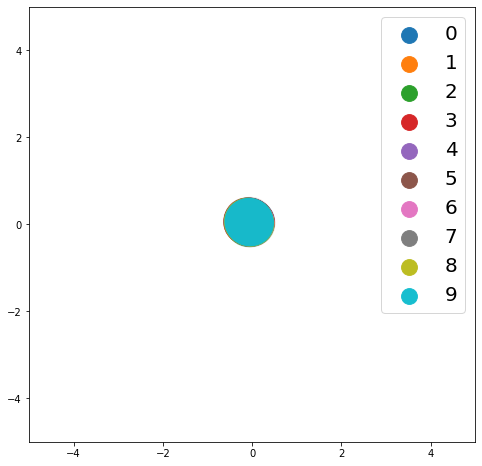

In [57]:
    
from matplotlib.patches import Ellipse

fig,ax =plt.subplots(figsize=(8,8))

for key in range(10):
    sct = ax.scatter(encoding[key][:,0],encoding[key][:,1],label=str(key),s=1.5)
    for p in zip(encoding[key], encoding_std[key]):
        el = Ellipse(xy=p[0],width=p[1][0],height=p[1][1],angle=0)
        el.set_facecolor(sct.get_facecolor()[0])
        el.set_alpha(0.2)
        ax.add_artist(el)
        
        
lgnd = ax.legend(fontsize=20)
for i in range(10):
    lgnd.legendHandles[i]._sizes = [250]


ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
plt.show()

## Now we are adding the KL divergence to our loss function,
## because we want the encoding Z to be close to N(0,1)

In [66]:
mse_l = nn.MSELoss(reduction='sum')


def loss_function(recon_x,x,mu,logvar):
    
    
    MSE = mse_l(recon_x, x.view(-1, 784))

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    

    return MSE, KLD

In [ ]:
vae.load_state_dict(torch.load('VAE.pt',map_location=torch.device('cpu')))

In [1]:
vae = VAE()
perp_loss = PerceptualLoss()


optimizer = optim.Adam(vae.parameters(), lr=1e-3) 

if torch.cuda.is_available():
    vae.cuda()
    perp_loss.cuda()
    
vae.train()



for epoch in range(10) :
    print(epoch)
    for x,y in tqdm( train_loader):
        optimizer.zero_grad()
        
        if torch.cuda.is_available():
            x = x.cuda()
            
        prediction,mu,logvar = vae(x)
        
        mse,kld = loss_function(prediction,x,mu,logvar)
        
        p_loss = perp_loss(prediction.view(-1,1,28,28), x)
        
        loss = mse+3*kld+300*p_loss
        
        loss.backward()
        optimizer.step()
        
    clear_output(wait=True)

    

In [68]:
vae.cpu()
vae.eval()

encoding = {}
encoding_std = {}

n_test = len(test_set)

for test_i in tqdm( range(n_test) ):
    x,y = test_set[test_i]
    
    if y not in encoding:
        encoding[y] = []
        encoding_std[y] = []
        
    enc_mean, enc_std = vae.enc(x.view(-1, 784))
    
    encoding[y].append( enc_mean.data.numpy()[0] )
    encoding_std[y].append( np.exp(0.5*enc_std.data.numpy()[0]) )
    
for key in encoding:
    encoding[key] = np.array(encoding[key])
    encoding_std[key] = np.array(encoding_std[key])

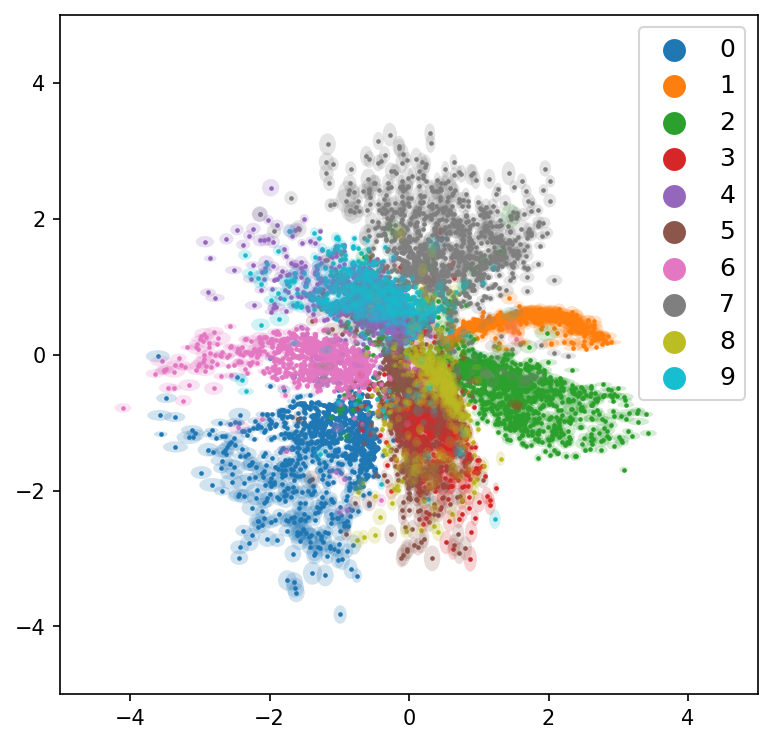

In [69]:
from matplotlib.patches import Ellipse

fig,ax =plt.subplots(figsize=(6,6),dpi=150)

for key in range(10):
    sct = ax.scatter(encoding[key][:,0],encoding[key][:,1],label=str(key),s=1.5)
    for p in zip(encoding[key], encoding_std[key]):
        el = Ellipse(xy=p[0],width=p[1][0],height=p[1][1],angle=0)
        el.set_facecolor(sct.get_facecolor()[0])
        el.set_alpha(0.2)
        ax.add_artist(el)
        
        
lgnd = ax.legend(fontsize=12)
for i in range(10):
    lgnd.legendHandles[i]._sizes = [100]


ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
plt.show()

## we don't need an input image anymore, we can use any point in the latent space to generate an image

In [58]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import FloatSlider

In [70]:
def generate_img(x,y):
    fig,ax = plt.subplots(1,3,figsize=(8,4))
    img_mean, img_std = vae.dec(torch.FloatTensor([x,y]))
    img_std = torch.exp(0.5*img_std)
    
    reco_img = img_mean+img_std*torch.randn_like(img_std)
    ax[0].imshow( img_mean.data.numpy().reshape(28,28) ,cmap='gray',vmin=0,vmax=1)
    ax[1].imshow( img_std.data.numpy().reshape(28,28) ,cmap='gray')
    ax[2].imshow( reco_img.data.numpy().reshape(28,28) ,cmap='gray',vmin=0,vmax=1)

    plt.show()

interactive_plot = interactive(generate_img, x=FloatSlider(min=-4.0, max=4.0, step=0.01, continuous_update=False)
                               , y=FloatSlider(min=-4.0, max=4.0, step=0.01, continuous_update=False))
interactive_plot

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='x', max=4.0, min=-4.0, step…